In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Importing Libraries

In [3]:
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [4]:
root_dir = Path('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT')

In [5]:
categories = ['benign', 'malignant']

# Function to load image paths and labels
def load_image_paths_and_labels(root_dir, categories):
    image_paths = []
    labels = []
    
    for label, category in enumerate(categories):
        category_path = root_dir / category
        for img_path in category_path.glob('*.png'):  # Assuming images are in PNG format
            image_paths.append(img_path)
            labels.append(label)  # 0 for benign, 1 for malignant
            
    return np.array(image_paths), np.array(labels)

# Load image paths and labels
image_paths, labels = load_image_paths_and_labels(root_dir, categories)

## Data Visualization

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

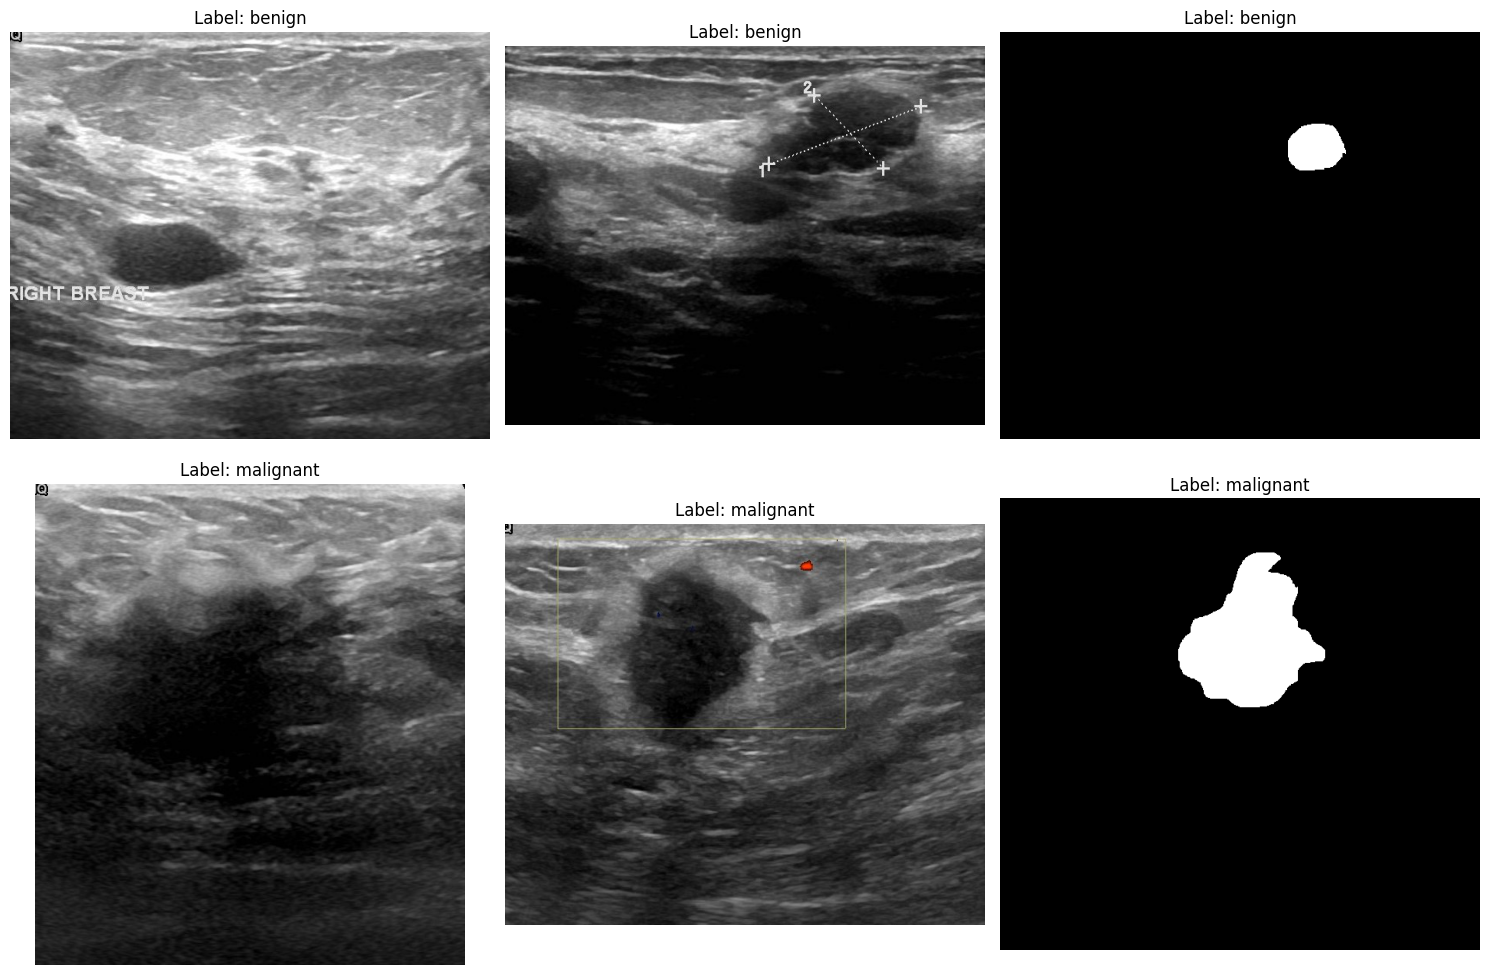

In [11]:
def visualize_balanced_images(image_paths, labels, categories, num_images_per_category=3):
    """
    Visualizes a balanced number of images from each category.

    Parameters:
    - image_paths: Array of image file paths.
    - labels: Array of corresponding labels.
    - categories: List of category names.
    - num_images_per_category: Number of images to display per category.
    """
    plt.figure(figsize=(15, 10))
    
    # Loop through each category
    for category_idx, category in enumerate(categories):
        category_indices = np.where(labels == category_idx)[0]
        selected_indices = category_indices[:num_images_per_category]  # Select first few images
        
        for i, idx in enumerate(selected_indices):
            img = Image.open(image_paths[idx])
            plt.subplot(len(categories), num_images_per_category, category_idx * num_images_per_category + i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f"Label: {category}", fontsize=12)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize a balanced number of images from both categories
visualize_balanced_images(image_paths, labels, categories, num_images_per_category=3)


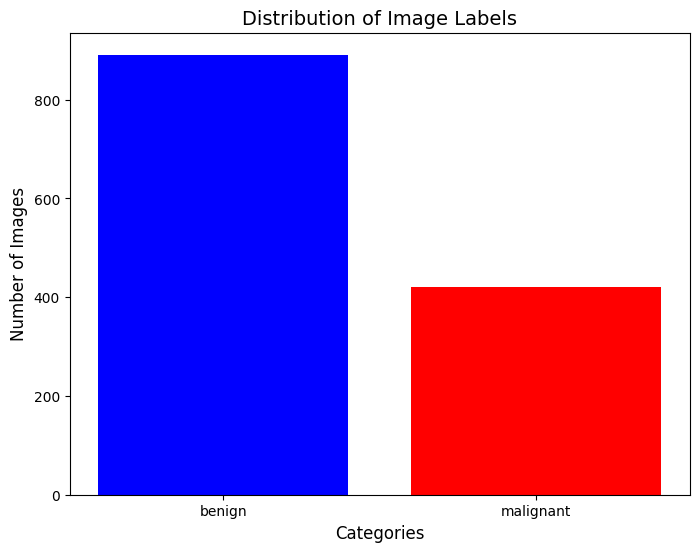

In [12]:
def visualize_label_distribution(labels, categories):
    """
    Visualizes the distribution of labels in the dataset.

    Parameters:
    - labels: Array of corresponding labels.
    - categories: List of category names.
    """
    plt.figure(figsize=(8, 6))
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(categories, counts, color=['blue', 'red'])
    plt.title("Distribution of Image Labels", fontsize=14)
    plt.xlabel("Categories", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.show()

# Visualize label distribution
visualize_label_distribution(labels, categories)

## Splitting the dataset

In [13]:
# Splitting into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=101
)

## Data Preprocessing

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Preprocess image function
def preprocess_image(image_path, label):
    # Read the image from the path
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode the image
    image = tf.image.resize(image, [64, 64])  # Resize to match model input shape
    image = image / 255.0  # Normalize image to [0, 1]
    return image, label

In [15]:
# Dataset creation function
def create_dataset(image_paths, labels, batch_size=32):
    image_paths = [str(path) for path in image_paths]  # Ensure paths are strings
    labels = tf.convert_to_tensor(labels)  # Convert labels to Tensor
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))  # Create dataset
    dataset = dataset.map(lambda x, y: preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)  # Preprocess images
    dataset = dataset.batch(batch_size)  # Batch the dataset
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Prefetch for performance
    return dataset

## Data Augmentation

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the image augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [17]:
# Define the CNN model architecture
model = models.Sequential([
    layers.InputLayer(input_shape=(64, 64, 3)),  

    # First Convolutional Layer
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # 32 filters, 3x3 kernel
    layers.MaxPooling2D((2, 2), padding='same'),  # Max Pooling with 2x2 window

    # Second Convolutional Layer
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),

    # Second Convolutional Layer
    layers.Conv2D(10, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    
    # Flatten the output from Conv layers to feed into fully connected layers
    layers.Flatten(),

    # Fully Connected Layers
    layers.Dense(128, activation='relu'),  # Fully connected layer with 512 neurons
    layers.Dropout(0.3),  # Dropout layer for regularization

    # Output Layer
    layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [18]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 10)     │         2,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,323 (411.42 KB)

 Trainable params: 105,323 (411.42 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
class DisplayImageAtEpoch(tf.keras.callbacks.Callback):
    def __init__(self, val_data, epoch_interval=1):
        super().__init__()
        self.val_data = val_data
        self.epoch_interval = epoch_interval
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.epoch_interval == 0:
            # Take a sample image from validation data (or from the batch)
            image, label = next(iter(self.val_data))
            image = image[0].numpy()  # Get the first image from the batch
            
            # Display the image using matplotlib
            plt.imshow(image)
            plt.axis('off')  # Turn off axis
            plt.title(f"Epoch {epoch + 1}")
            plt.show()

In [32]:
# Create the display image callback
display_image_callback = DisplayImageAtEpoch(test_dataset, epoch_interval=1)

In [20]:
# Create training and test datasets
train_dataset = create_dataset(X_train, y_train)
test_dataset = create_dataset(X_test, y_test)

In [22]:
# EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8616 - loss: 0.3337

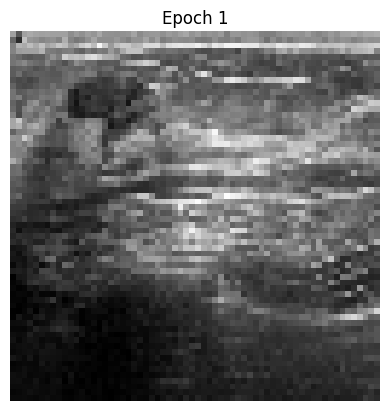

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - accuracy: 0.8616 - loss: 0.3333 - val_accuracy: 0.7871 - val_loss: 0.5331
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.8767 - loss: 0.3165

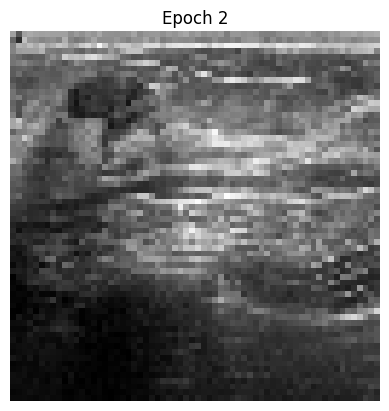

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step - accuracy: 0.8767 - loss: 0.3160 - val_accuracy: 0.7643 - val_loss: 0.5728
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8831 - loss: 0.2647

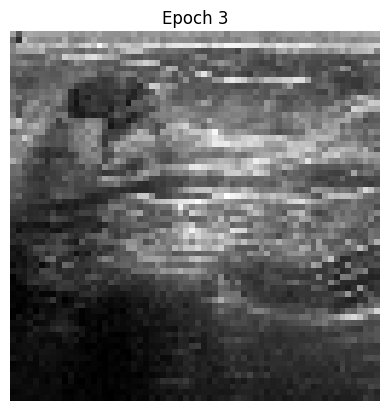

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - accuracy: 0.8831 - loss: 0.2645 - val_accuracy: 0.7833 - val_loss: 0.5705


In [33]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
    callbacks=[early_stopping, display_image_callback]
)

In [34]:
# Evaluate the model on test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7839 - loss: 0.5696
Test Accuracy: 78.71%


## Single Image Prediction

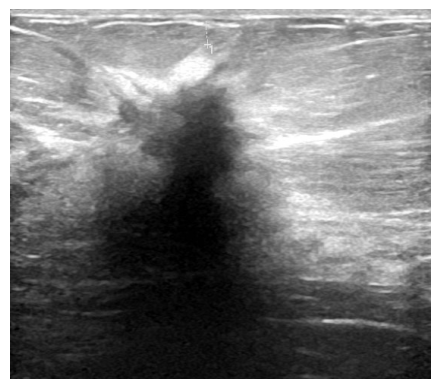

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction: MALIGNANT


In [30]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from PIL import Image

def predict_image(image_path, model):
    # Load the image, resize to the target size expected by the model
    test_image = image.load_img(image_path, target_size=(64, 64))  # Change target size if needed
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    result = model.predict(test_image)

    if result[0][0] == 1:
        prediction = 'MALIGNANT'
    else:
        prediction = 'BENIGN'

    return prediction



image_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (103).png'
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()
prediction = predict_image(image_path, model) 
print(f"Prediction: {prediction}")

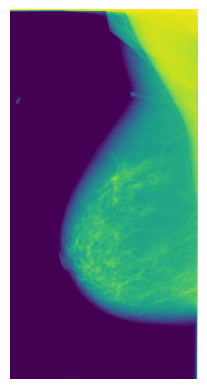

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction: BENIGN


In [35]:
image_path = '/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.100682860911308271813943300011840547108/1-198.jpg'
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()
prediction = predict_image(image_path, model) 
print(f"Prediction: {prediction}")